# Model

In [33]:
import pandas as pd
from constants import *
import numpy as np
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
train = pd.read_pickle(TRAIN)
test = pd.read_pickle(TEST)

Create a 70/30 train/validation split of the training data and also a small sample to speed up testing:

In [3]:
val_set = (train[["user_id"]]
           .drop_duplicates()
           .assign(val_flag = True)
           .sample(frac = .3, random_state = 152)
           .set_index("user_id"))
val_bool = train[["user_id"]].join(val_set, on = "user_id")[["val_flag"]].notnull()
train.eval_set[val_bool.val_flag.values] = "val"

In [4]:
train_set_small = (train[train.eval_set == "train"][["user_id"]]
                   .drop_duplicates()
                   .assign(small_flag = True)
                   .sample(frac = .2, random_state = 152)
                   .set_index("user_id"))
small_bool = train[["user_id"]].join(train_set_small, on = "user_id")[["small_flag"]].notnull()
train.eval_set[small_bool.small_flag.values] = "train_small"

In [5]:
train.groupby("eval_set").agg({"user_id": "nunique"})

,user_id
eval_set,
train,73477
train_small,18369
val,39363


### Helpers

In [6]:
def f1_score_per_order(truth_str, pred_str):
    truth_set = set(truth_str.split())
    pred_set = set(pred_str.split())
    tp = len(truth_set & pred_set)
    if tp == 0:
        return 0.
    p = 1. * tp / len(pred_set)
    r = 1. * tp / len(truth_set)
    return 2 * p * r / (p + r)

In [7]:
def f1_score(truth_list, pred_list):
    return np.mean([f1_score_per_order(x, y) for x, y in zip(truth_list, pred_list)])

In [8]:
def collapse(x):
    product_list = filter(lambda y: y != "", x)
    if len(product_list) == 0:
        return "None"
    else:
        return " ".join(map(str, product_list))

def binaryPredictionToString(X, preds, thr):
    mat = X[["order_id", "product_id"]]
    mat = mat.assign(products = map(lambda (pid, pr): "" if pr < thr else pid,
                                    zip(mat.product_id, preds)))
    preds_str = mat.groupby("order_id").agg({
        "products": collapse
    })
    return preds_str
    
def evaluate(X, y, preds, thr = np.linspace(.18, .22, 8)):
    truth_str = binaryPredictionToString(X, y, .5)
    rv = dict()
    for t in thr:
        pred_str = binaryPredictionToString(X, preds, t)
        rv[t] = f1_score(truth_str.values.flatten(), pred_str.values.flatten())
    return rv

### Model Training

In [9]:
def buildDMatrix(X, y = None):
    cols_to_drop = ["user_id", "order_id", "product_id", "eval_set", "ordered"]
    cols_to_drop_present = list(set(cols_to_drop) & set(X.columns.values))
    X_dr = X.drop(cols_to_drop_present, axis = 1)
    if y is not None:
        dm = xgb.DMatrix(
            X_dr.values, label = y.values, feature_names = X_dr.columns.values)
    else:
        dm = xgb.DMatrix(
            X_dr.values, feature_names = X_dr.columns.values)
    return dm

In [10]:
def trainModel(X, y, X_test, y_test = None, model_params = {}, num_boost_round = 80):
    
    # Build DMatrices
    train_dm = buildDMatrix(X, y)
    if X_test is not None:
        test_dm = buildDMatrix(X_test, y_test)
    
    # Fit model
    model = xgb.train(model_params, train_dm, num_boost_round = num_boost_round)
    
    # Get training predictions
    train_predictions = model.predict(train_dm)
    
    # Get test predictions
    if X_test is not None:
        test_predictions = model.predict(test_dm)
    
    # Evaluate on train
    train_scores = evaluate(X, y, train_predictions)
    
    # If test labels known, evaluate on test
    test_scores = None
    if y_test is not None:
        test_scores = evaluate(X_test, y_test, test_predictions)
    
    return {
        "model": model,
        "train_f1_scores": train_scores,
        "test_f1_scores": test_scores,
        "test_predictions": test_predictions
    }

In [23]:
params = {
  "objective": "reg:logistic",
  "eval_metric": "logloss",
  "eta": 0.03,
  "max_depth": 6,
  "min_child_weight": 10,
  "gamma": 0.70,
  "subsample": 0.76,
  "colsample_bytree": 0.95,
  "alpha": 3e-05,
  "lambda": 10
}

Local Validation:

In [20]:
X_train = train[train.eval_set == "train_small"]
y_train = train.ordered[train.eval_set == "train_small"]
X_test = train[train.eval_set == "val"]
y_test = train.ordered[train.eval_set == "val"]
model_train = trainModel(
    X_train, y_train, X_test, y_test, params, 250)

In [21]:
pd.DataFrame({
    "Threshold": model_train["train_f1_scores"].keys(),
    "Training F1": model_train["train_f1_scores"].values(),
    "Test F1": model_train["test_f1_scores"].values()
}).set_index("Threshold").sort_index()

,Test F1,Training F1
Threshold,,
0.180000,0.377067,0.384773
0.185714,0.377667,0.385202
0.191429,0.377635,0.385326
0.197143,0.377782,0.384910
0.202857,0.377873,0.384491
0.208571,0.377577,0.383948
0.214286,0.377401,0.383194
0.220000,0.376741,0.382035


In [14]:
# test_scores = evaluate(
#     X_test, y_test, model_train["test_predictions"])

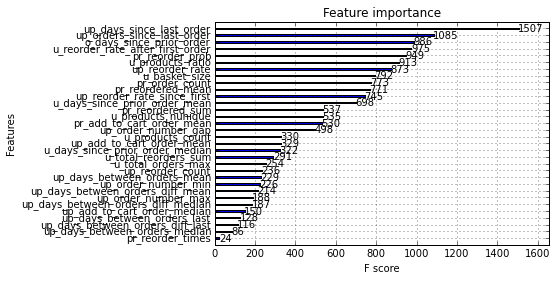

In [15]:
# xgb.plot_importance(model_train["model"])

Build Submission:

In [24]:
# X_train = train
# y_train = train.ordered
# X_test = test
# y_test = None
# model_train = trainModel(
#     X_train, y_train, X_test, y_test, params, 250)

In [25]:
# pred_str = binaryPredictionToString(X_test, model_train["test_predictions"], .191)
# pred_str.to_csv("./data/new_features_tuning.csv")

In [ ]:
# train_preds = model_train["model"].predict(buildDMatrix(X_train))
# X_train.assign(training_preds = train_preds).to_pickle(THRESHOLD_TRAINING)